# Requirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
import plotly.graph_objects as go

## Simulation functions

In [2]:

def sim_mbeu(n_trayectories: int, n_periods: int) -> np.ndarray:
  mbeu = np.zeros((n_trayectories, n_periods + 1));

  std = np.sqrt(1 / n_periods);
  for n in range(1, n_periods+1):
    mbeu[:, n] = mbeu[:, n-1] + std *  np.random.normal(size=n_trayectories)

  return mbeu

def sim_bridge(n_trayectories: int, n_periods: int, n_bridge: int) -> np.ndarray:
  mbeu = sim_mbeu(n_trayectories, n_periods)
  bridge = mbeu


  for n in range(1, n_periods+1):
    t = n/n_periods;
    bridge[:, n] = n_bridge*mbeu[:, n] - t*mbeu[:, -1]

  return bridge

def sim_drift(n_trayectories: int, n_periods: int, mu_drift: float, sigma_drift: float) -> np.ndarray:
  mbeu = sim_mbeu(n_trayectories, n_periods)
  drift = mbeu


  for n in range(1, n_periods+1):
    t = n/n_periods;
    drift[:, n] = mu_drift*t - sigma_drift*mbeu[:, n]

  return drift

def sim_geometric(n_trayectories: int, n_periods: int, alpha_geom: float, lambda_geom: float) -> np.ndarray:
  mbeu = sim_mbeu(n_trayectories, n_periods)
  geometric = mbeu


  for n in range(0, n_periods+1):
    t = n/n_periods;
    geometric[:, n] = np.exp(alpha_geom * t - lambda_geom*mbeu[:, n])

  return geometric



## Plot functions

In [14]:
def plot_2d(n_trayectories, n_periods, stochastic_process='mbeu',
            n_bridge=1, mu_drift=0, sigma_drift=1, alpha_geom=0, lambda_geom=1):
  # Initiallize.
  T = np.linspace(0, 1, n_periods + 1);
  # Parameters.
  dict_fig = {
      'mbeu' : {
          'mean' : np.zeros(n_periods+1),
          'var' : T,
          'title' : f'Movimiento Browniano Estándar Univariado',
          'sim' : sim_mbeu(n_trayectories, n_periods)
          },
      'bridge' : {
          'mean' : np.zeros(n_periods+1),
          'var' : T - np.power(T, 2),
          'title' : f'Movimiento Bridge con $n=${n_bridge}',
          'sim' : sim_bridge(n_trayectories, n_periods, n_bridge=n_bridge)
          },
      'drift' : {
          'mean' : mu_drift * T,
          'var' : np.power(sigma_drift, 2) * T,
          'title' : f'Movimiento Drift con $\mu$={mu_drift} y $\sigma$={sigma_drift}',
          'sim' : sim_drift(n_trayectories, n_periods, mu_drift=mu_drift, sigma_drift=sigma_drift)
          },
      'geom' : {
          'mean' : np.exp((alpha_geom + np.power(lambda_geom, 2) / 2) * T),
          'var' : np.exp((2 * alpha_geom + np.power(lambda_geom, 2)) * T) *  (np.exp(np.power(lambda_geom, 2) * T)-1),
          'title' : rf'Movimiento Geométrico con $\alpha$={alpha_geom} y $\lambda$={lambda_geom}',
          'sim' : sim_geometric(n_trayectories, n_periods, alpha_geom=alpha_geom, lambda_geom=lambda_geom)
          }
      }[stochastic_process]

  W = dict_fig['sim']

  # Plot trayectories.
  plt.figure(figsize=(10, 6))
  for i in range(n_trayectories):
      plt.plot(T, W[i, :], alpha=0.7, linewidth=0.7, color='#0098E4')
  # Plot empirical.
  plt.plot(T, np.mean(W, axis=0), color='#D00000')
  plt.plot(T, np.var(W, axis=0), color='#D00000')
  # Plot teoretical.
  plt.plot(T, dict_fig['mean'], color='k', linestyle='--', linewidth=0.9)
  plt.plot(T, dict_fig['var'], color='k', linestyle='--', linewidth=0.9)
  # Titles.
  plt.xlabel("$t$")
  plt.ylabel("$W_t$")
  plt.title(f"{dict_fig['title']} (N={n_periods}, k={n_trayectories})")
  plt.grid(True)

  # Add legend.
  legend_elements = [
      Line2D([0], [0], color='#0098E4', lw=2, label="Trayectorias"),
      Line2D([0], [0], color='#D00000', lw=2, label="Media y Varianza Empírica"),
      Line2D([0], [0], color='k', linestyle='--', lw=1, label="Media y Varianza Teórica")
  ]
  plt.legend(handles=legend_elements, loc="upper left")

  plt.show()

def plot_cov(n_trayectories, n_periods, stochastic_process='mbeu',
             n_bridge=1, mu_drift=0, sigma_drift=1, alpha_geom=0, lambda_geom=1):
  # Initiallize.
  T = np.linspace(0, 1, n_periods + 1);
  X, Y = np.meshgrid(T, T)

  # Parameters.
  dict_fig = {
      'mbeu' : {
          'cov' : np.minimum(X, Y),
          'title' : 'Movimiento Browniano Estándar Univariado',
          'sim' : sim_mbeu(n_trayectories, n_periods)
            },
      'bridge' : {
          'cov' : np.minimum(X, Y) - X * Y,
          'title' : f'Movimiento Bridge con $n=${n_bridge}',
          'sim' : sim_bridge(n_trayectories, n_periods, n_bridge=n_bridge)
          },
      'drift' : {
          'cov' : np.power(sigma_drift, 2) * np.minimum(X, Y),
          'title' : f'Movimiento Drift con $\mu$={mu_drift} y $\sigma$={sigma_drift}',
          'sim' : sim_drift(n_trayectories, n_periods, mu_drift=mu_drift, sigma_drift=sigma_drift)
          },
      'geom' : {
          'cov' : np.exp((alpha_geom + np.power(lambda_geom, 2) / 2) * (X + Y)) * (np.exp(np.power(lambda_geom, 2) * np.minimum(X, Y)) - 1),
          'title' : rf'Movimiento Geométrico con $\alpha$={alpha_geom} y $\lambda$={lambda_geom}',
          'sim' : sim_geometric(n_trayectories, n_periods, alpha_geom=alpha_geom, lambda_geom=lambda_geom)
          }
        }[stochastic_process]

  W = dict_fig['sim']
  sim_cov_matrix = np.cov(np.transpose(W))

  # Plot trayectories.
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  surf1 = ax.plot_surface(X, Y, dict_fig['cov'], alpha=0.5, edgecolor='none', color='k')
  surf2 = ax.plot_surface(X, Y, sim_cov_matrix, alpha=0.2, edgecolor='none', cmap='viridis')

  ax.set_xlabel("$t$")
  ax.set_ylabel("$s$")
  ax.set_zlabel("$\mathrm{Cov}(W_t, W_s)$")
  ax.set_title(f"{dict_fig['title']} (N={n_periods}, k={n_trayectories})")

  legend_elements = [
      Line2D([0], [0], color="black", lw=1, label=r"Covarianza Teórica"),
      Line2D([0], [0], color="purple", lw=1, label=r"Covarianza Empírica")
  ]
  ax.legend(handles=legend_elements, loc="upper left")

  fig.show()

# Plot Trayectories, Mean and Variance

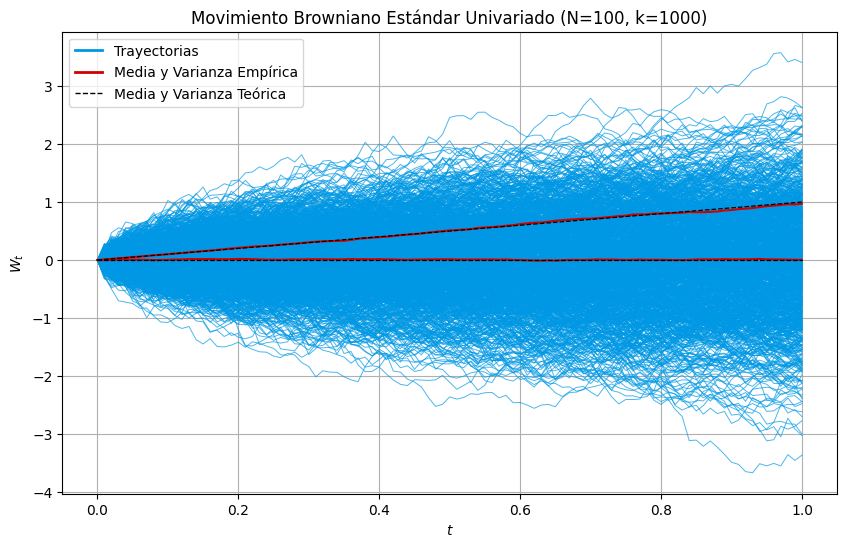

In [5]:
plot_2d(k, N)

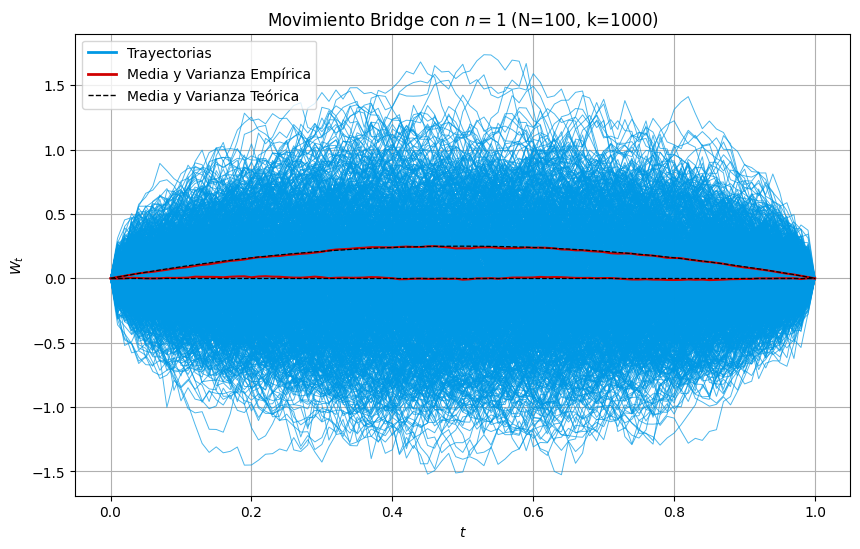

In [6]:
plot_2d(k, N, 'bridge', n_bridge=1)

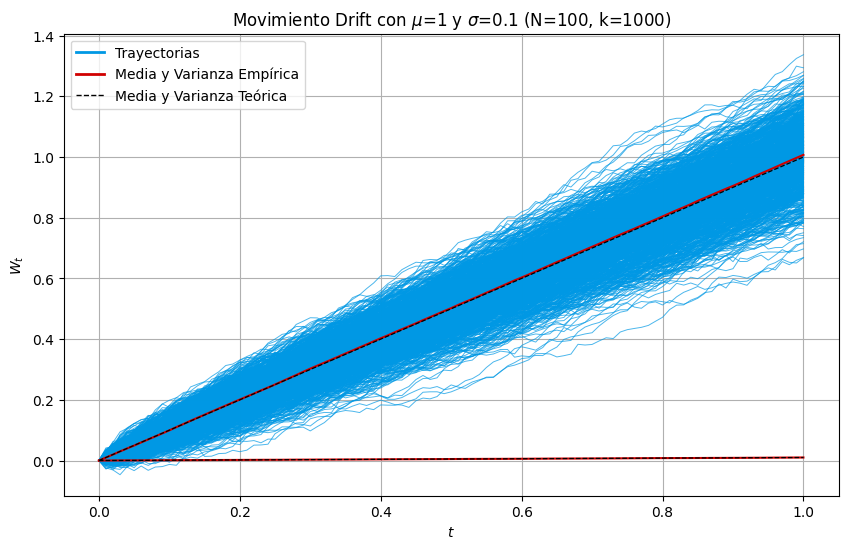

In [7]:
plot_2d(k, N, 'drift', mu_drift=1, sigma_drift=0.1)

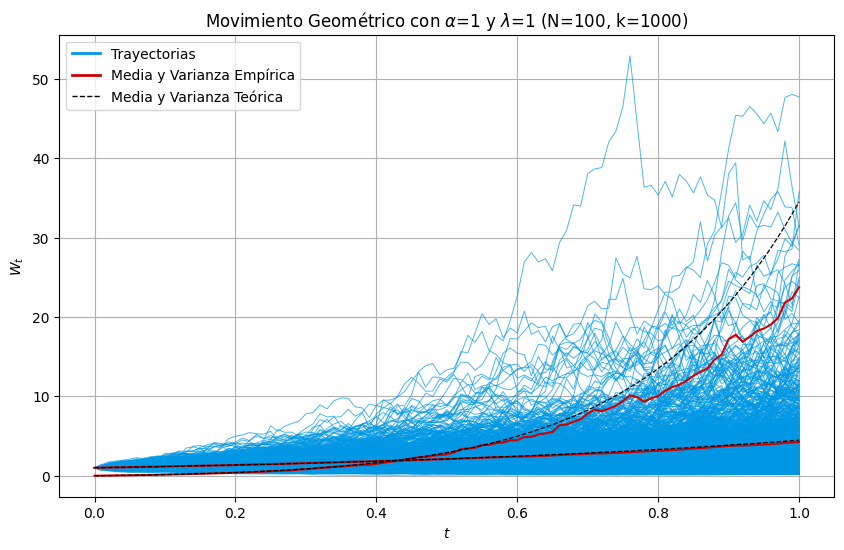

In [8]:
plot_2d(k, N, 'geom', alpha_geom=1, lambda_geom=1)

# Plot Covariance

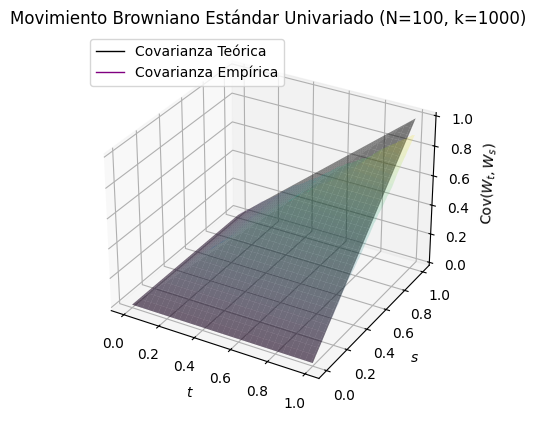

In [10]:
plot_cov(k, N, 'mbeu')

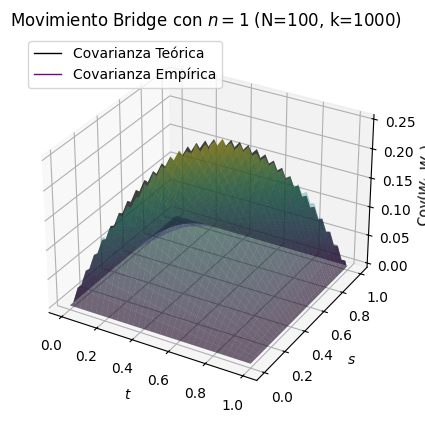

In [11]:
plot_cov(k, N, 'bridge')

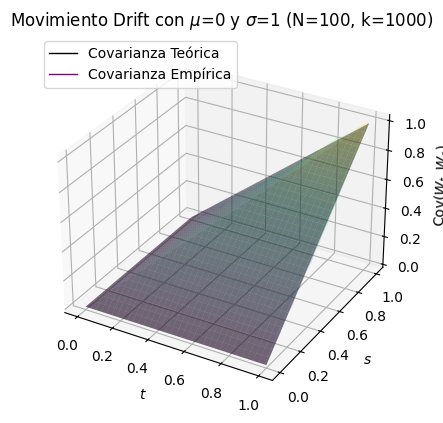

In [12]:
plot_cov(k, N, 'drift')

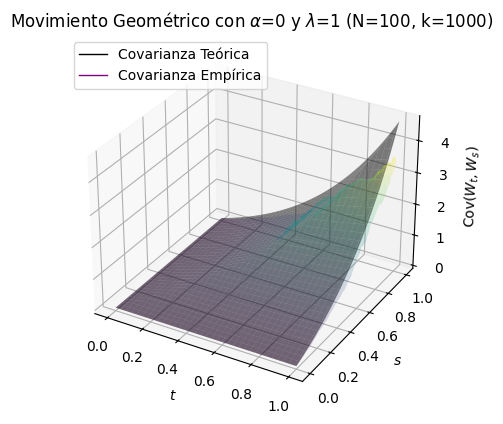

In [13]:
plot_cov(k, N, 'geom')